<a href="https://colab.research.google.com/github/rafsanlab/etc/blob/main/AE_Simple_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and configs

In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# import to read tiff
!pip install libtiff
from libtiff import TIFF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for libtiff: filename=libtiff-0.4.2-cp38-cp38-linux_x86_64.whl size=302068 sha256=79402912ce3a732d09b852fd91f6dbc45487440a741f1be3bca4729117015469
  Stored in directory: /root/.cache/pip/wheels/70/ef/75/99ce530b01b6a5bef81ebed8c05bd7713ca298e21b5635dbac
Successfully built libtiff
Generating '/usr/local/lib/python3.8/dist-packages/libtiff/tiff_h_4_1_0.py' from '/usr/include/x86_64-linux-gnu/tiff.h'


In [ ]:
# install torch_snippets for Dataset class
!pip install -q torch_snippets pytorch_model_summary
from torch_snippets import *

## Get the data

In [15]:
# get path to the image folder
from pathlib import Path

PATH_BASE = Path('/content/drive/Shareddrives/CHEMPREDICT-DL/01_Data/01 - H+E Images plus annotations/Images_H_E/Consecutive Cohort/ConsecCohort_9 TMAs_H_E Images_cores/extracted_cores/tma1/cores')
PATH_IMG = list(PATH_BASE.glob('*.tiff'))

for i in PATH_IMG: print(i); break
print(len(PATH_IMG))

/content/drive/Shareddrives/CHEMPREDICT-DL/01_Data/01 - H+E Images plus annotations/Images_H_E/Consecutive Cohort/ConsecCohort_9 TMAs_H_E Images_cores/extracted_cores/tma1/cores/tma1_0_8.tiff
130


In [16]:
# class to open the images
class OpenData():

  import cv2

  def __init__(self, PATH_IMG):
    self.PATH_IMG = PATH_IMG
  
  def __len__(self):
    return len(self.PATH_IMG)

  def __getitem__(self, i):
    img = self.PATH_IMG[i]
    img = TIFF.open(img)
    img = img.read_image()
    img = cv2.resize(img, [256, 256])
    transform = transforms.ToTensor()
    tnsr = transform(img)
    return tnsr

In [17]:
# create train and test dataset
num_workers = 0
batch_size = 10

# get the data
train_data = OpenData(PATH_IMG)
test_data = OpenData(PATH_IMG)

# get the data loader
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers)

In [19]:
import cv2

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
imgs = next(dataiter)
imgs = imgs.numpy()

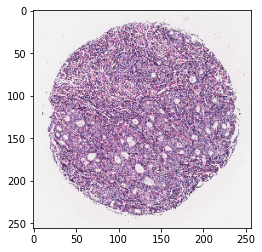

In [21]:
# plot one image
img = np.transpose(imgs[9], (1,2,0))
plt.imshow(img)

## Build the nets

In [112]:
# original code
'''
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)
'''

'\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n# define the NN architecture\nclass ConvAutoencoder(nn.Module):\n    def __init__(self):\n        super(ConvAutoencoder, self).__init__()\n        ## encoder layers ##\n        # conv layer (depth from 3 --> 16), 3x3 kernels\n        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  \n        # conv layer (depth from 16 --> 4), 3x3 kernels\n        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)\n        # pooling layer to reduce x-y dims by two; kernel and stride of 2\n        self.pool = nn.MaxPool2d(2, 2)\n        \n        ## decoder layers ##\n        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2\n        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)\n        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)\n\n    def forward(self, x):\n        ## encode ##\n        # add hidden layers with relu activation function\n        # and maxpooling after\n        x = F.relu(self.conv1(x))\n        x 

In [106]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)  
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 128, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(128, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)       
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv4(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (t_conv4): ConvTranspose2d(128, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [107]:
# specify loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [108]:
# config
n_epochs = 50
losses = []

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    
    ## train the model ##
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics 
    losses.append(train_loss)
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 6.222924
Epoch: 2 	Training Loss: 4.836235
Epoch: 3 	Training Loss: 4.533831
Epoch: 4 	Training Loss: 4.427700
Epoch: 5 	Training Loss: 4.393512
Epoch: 6 	Training Loss: 4.359215
Epoch: 7 	Training Loss: 4.295254
Epoch: 8 	Training Loss: 4.201825
Epoch: 9 	Training Loss: 4.130830
Epoch: 10 	Training Loss: 4.070872
Epoch: 11 	Training Loss: 4.024431
Epoch: 12 	Training Loss: 3.988555
Epoch: 13 	Training Loss: 3.957574
Epoch: 14 	Training Loss: 3.942787
Epoch: 15 	Training Loss: 3.931591
Epoch: 16 	Training Loss: 3.919050
Epoch: 17 	Training Loss: 3.904950
Epoch: 18 	Training Loss: 3.892270
Epoch: 19 	Training Loss: 3.883575
Epoch: 20 	Training Loss: 3.877931
Epoch: 21 	Training Loss: 3.874047
Epoch: 22 	Training Loss: 3.869629
Epoch: 23 	Training Loss: 3.865626
Epoch: 24 	Training Loss: 3.861064
Epoch: 25 	Training Loss: 3.858393
Epoch: 26 	Training Loss: 3.855363
Epoch: 27 	Training Loss: 3.852848
Epoch: 28 	Training Loss: 3.850804
Epoch: 29 	Training Loss: 3.8

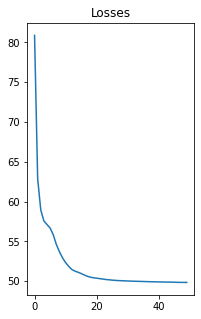

In [109]:
plt.figure(figsize=(3,5))
plt.title('Losses')
plt.plot(losses)

In [110]:
# helper function
def imshow(img): plt.imshow(np.transpose(img, (1, 2, 0)))

# get one batch of test images
dataiter = iter(test_loader)
images = next(dataiter)
images = next(dataiter)

# get sample outputs
output = model(images)
output = output.detach().numpy()
images = images.numpy()

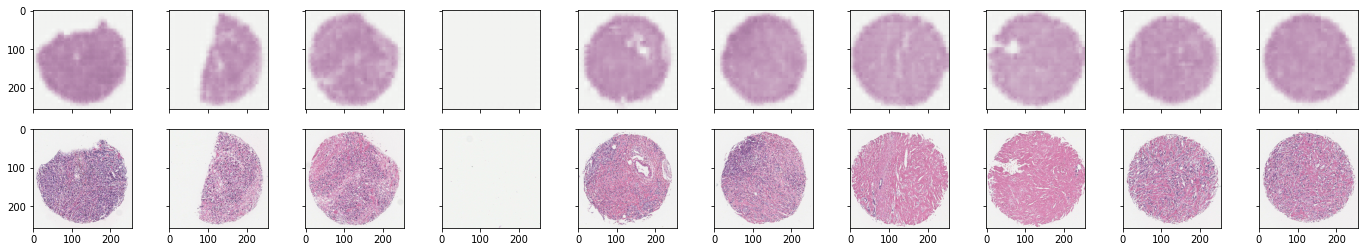

In [111]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharey=True, sharex=True, figsize=(24,4))
for i in np.arange(10):
  img = np.transpose(output[i], (1, 2, 0))
  axes[0,i].imshow(img)
  img = np.transpose(images[i], (1, 2, 0))
  axes[1,i].imshow(img)